In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## STEP 0: DATA PREP

In [2]:
# LOAD THE DATA
df_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Convert timestamp from string to datetime
df_raw['datetime_txt'] = df_raw['Date'] + " " + df_raw['Time hh:mm:ss.ddd']
df_raw['datetime'] = pd.to_datetime(df_raw['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

In [4]:
# Select Columns
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

In [5]:
# Compute 1 second averages
df_raw.set_index('datetime', inplace=True, drop = False)
df_raw = df_raw.resample('1s').mean()
df_raw = df_raw.reset_index(drop=True)
df_raw['datetime'] = df_raw['datetime'].dt.floor('s')

In [6]:
# Calculate elapsed time
df_raw['elapsed_time'] = df_raw['datetime'].diff().apply(lambda x: x.total_seconds())

In [7]:
# Merge GPS and activity data
df_raw = pd.merge(df_raw, gps, on='datetime', how='left')

In [8]:
# Apply a flag for 1st GPS fix of every hour
def mark_ground_truth(row):
    seconds = row['datetime'].second
    minute = row['datetime'].minute
    if seconds == 0  and minute == 0:
        return 1
    else:
        return 0
        
df_raw['ground_truth'] = df_raw.apply(mark_ground_truth,axis=1)

In [9]:
# Make a copy of the data
df = df_raw.copy()

In [10]:
# PLOT ACCELERATION OVER TIME
# Acc_x = df['Acc_x'].iloc[25:75]
# Acc_y = df['Acc_y'].iloc[25:75]
# Acc_z = df['Acc_z'].iloc[25:75]
# dt = df['datetime'].iloc[25:75]

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111)

# # Plot the trajectory
# ax.plot(dt, Acc_x, marker='o', linestyle='-', color='b', label='x')
# ax.plot(dt, Acc_y, marker='o', linestyle='-', color='r', label='y')
# ax.plot(dt, Acc_z, marker='o', linestyle='-', color='g', label='z')

# # Setting labels
# ax.set_xlabel('Time')
# ax.set_ylabel('Acceleration')

# # Adding a title and legend
# ax.set_title('Acceleration')
# ax.legend()

# # Show plot
# plt.show()

## STEP M1: COMPUTE ACCELERATION COMPONENTS
Static acceleration is the acceleration component due to the pull of gravity. Following Shepard et al. 2008, static acceleration can be approximated using a moving average. According to Shepard et al. 2008, the length of the running mean should correspond to the point (or follow the point) where calculated overall dynamic body acceleration (ODBA) stabizes.


In [11]:
# # WINDOW LENGTH SELECTION

# # Possible window lengths
# windows = [2,3,4,6,8,10,12,14,16,18,20]

# # Set up dataframe to store results
# acc_data = df[['Acc_x','Acc_y','Acc_z']]
# window_results = pd.DataFrame(columns = ['Acc_x','Acc_y','Acc_z','Gx','Gy','Gz','DAx','DAy','DAz','ODBA','WindowLength'])

# # Compute static acceleration using possible window lengths
# for win in windows:
#     # Get raw acceleration and set up results table
#     res = acc_data
#     # Compute static acceleration using rolling mean
#     res['Gx'] = res['Acc_x'].rolling(window=win).mean()
#     res['Gy'] = res['Acc_y'].rolling(window=win).mean()
#     res['Gz'] = res['Acc_z'].rolling(window=win).mean()
#     # Compute dynamic acceleration
#     res['DAx'] = res['Acc_x'] - res['Gx']
#     res['DAy'] = res['Acc_y'] - res['Gy']
#     res['DAz'] = res['Acc_z'] - res['Gz']
#     # Compute ODBA
#     res['ODBA'] = res['DAx'] ** 2 + res['DAy'] ** 2 + res['DAz'] ** 2
#     # Store Results
#     res['WindowLength'] = [win]*len(res)
#     res.head(10)
#     window_results = pd.concat([window_results, res], ignore_index=True)

# # Plot results
# grouped = window_results.groupby('WindowLength')['ODBA']
# means = grouped.mean()
# std_errors = grouped.sem()
# plt.errorbar(means.index, means, yerr=std_errors, fmt='o', color='blue', ecolor='lightblue', capsize=5)
# plt.xlabel('Running mean (s)')
# plt.ylabel('ODBA')
# plt.grid(True)
# plt.show()


In [12]:
# CALCULATE STATIC ACCELERATION
w = 10
df['Gx'] = df['Acc_x'].rolling(window=w).mean()
df['Gy'] = df['Acc_y'].rolling(window=w).mean()
df['Gz'] = df['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df = df.iloc[w-1:].reset_index(drop=True)

In [13]:
# CALCULATE DYNAMIC ACCELERATION
df['DAx'] = df['Acc_x']-df['Gx']
df['DAy'] = df['Acc_y']-df['Gy']
df['DAz'] = df['Acc_z']-df['Gz']

In [14]:
# CALCULATE VeDBA
df['VeDBA']= (df['DAx']**2 + df['DAy']**2 + df['DAz']**2)**0.5

## STEP M2: COMPUTE PITCH AND ROLL
- Pitch = rotation about the lateral axis
- Roll = rotation about the anterior-posterior axis
- Yaw (heading) = rotation about the dorso-ventral axis.

In [15]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [16]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

## STEP M3: NORMALIZE COMPASS DATA

In [17]:
# Function to compute normalization factor
def calc_normalization_factor(row):
    Mx = row['Mag_x']
    My = row['Mag_y']
    Mz = row['Mag_z']
    fm = math.sqrt(Mx**2 + My**2 + Mz**2)
    return fm

# Compute normalization factor
df['fm'] = df.apply(calc_normalization_factor,axis=1)

# Normalize compass data
df['NMx'] = df['Mag_x']/df['fm']
df['NMy'] = df['Mag_y']/df['fm']
df['NMz'] = df['Mag_z']/df['fm']

## STEP M4: ROTATE AXES ACCORDING TO PITCH AND ROLL 

In [18]:
# Function to generate pitch rotation matrix

def get_rx(pitch):
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),math.sin(pitch)],
          [0,-math.sin(pitch),math.cos(pitch)]])
    return Rx

# Function to generate roll rotation matrix
def get_ry(roll):
    Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
         [0,1,0],
         [math.sin(roll),0,math.cos(roll)]])
    return Ry

# Function to generate yaw rotation matrix
def get_rz(yaw):
    Rz = np.array([[math.cos(yaw), math.sin(yaw),0],
                 [-math.sin(yaw), math.cos(yaw), 0],
                 [0,0,1]])
    return Rz

## STEP M5: DERIVE HEADING

In [19]:
# Function to derive heading
def get_yaw(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    pitch = row['pitch']
    roll = row['roll']
    yaw = np.arctan2(
    NMx * np.cos(roll) - NMz * np.sin(roll),
    NMx * np.cos(pitch) + NMy * np.sin(pitch) * np.sin(roll) + NMz * np.sin(pitch) * np.cos(roll)
    )
    return yaw

# Calculate heading
df['yaw'] = df.apply(get_yaw,axis = 1)

## STEP M6: CALCULATE SPEED FROM VEDBA

In [20]:
# Initialize constants with nominal values
# These will be changed later on when aligning dead-reckoned trajectories with GPS

m = 1
c = 0.1
df['m'] = m # constant of proportionality
df['c'] = c # constant

# Calculate speed (speed = (m*VeDBA)+c
df['s'] = m*df['VeDBA'] + c

# Calculate distance (distance = speed * time)
df['d'] = df['s'] * df['elapsed_time']
df.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,roll,fm,NMx,NMy,NMz,yaw,m,c,s,d
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,...,0.107142,0.273992,0.202447,0.246999,-0.947632,1.241688,1,0.1,0.167368,0.167368
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,1.0,25/02/2019,22:24:10,...,0.133071,0.272872,0.209362,0.245866,-0.946424,1.314241,1,0.1,0.150423,0.150423
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,1.0,25/02/2019,22:24:11,...,0.154322,0.273152,0.227649,0.239447,-0.943844,1.339237,1,0.1,0.122824,0.122824
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,1.0,25/02/2019,22:24:12,...,0.168681,0.270951,0.285002,0.210575,-0.935111,1.277772,1,0.1,0.118788,0.118788
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,1.0,25/02/2019,22:24:13,...,0.172698,0.269132,0.296998,0.202837,-0.933086,1.269775,1,0.1,0.118747,0.118747
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,1.0,25/02/2019,22:24:14,...,0.175549,0.268531,0.305027,0.200109,-0.931083,1.264653,1,0.1,0.113771,0.113771
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,1.0,25/02/2019,22:24:15,...,0.177614,0.268094,0.314267,0.196064,-0.928868,1.256481,1,0.1,0.116719,0.116719
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,1.0,25/02/2019,22:24:16,...,0.180703,0.268412,0.317169,0.195741,-0.927949,1.259084,1,0.1,0.113428,0.113428
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,1.0,25/02/2019,22:24:17,...,0.183324,0.267701,0.312995,0.195531,-0.929409,1.270705,1,0.1,0.114498,0.114498
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,1.0,25/02/2019,22:24:18,...,0.185023,0.270803,0.306074,0.202126,-0.930303,1.283493,1,0.1,0.112322,0.112322


## STEP M7: PERFORM DEAD RECKONING CALCULATION

In [21]:
def dead_reckoning_magnetometer(acc_data, ground_truth_points):

    """
    This function calculates dead reckoning trajectories from accelerometer and magnetometer data and aligns the calculated trajectory with
    ground truth points.

    Args:
    acc_data (pandas df): accelerometery data 
    ground_truth_points (pandas df): ground truth points

    Returns:
    trajectory (pandas df): dead reckoned trajectory
    """

    # Filter DF to perform dead reckoning between first and last GTP
    # Get ground truth points
    gtp_start = ground_truth_points.iloc[0]
    gtp_end = ground_truth_points.iloc[-1]

    # Get timestamps of GTPs
    gtp_start_ts = gtp_start['datetime']
    gtp_end_ts = gtp_end['datetime']

    # Filter for DR pts that fall between gtp1 and gtp2
    acc_data = acc_data[(acc_data['datetime'] >= gtp_start_ts) & (acc_data['datetime'] <= gtp_end_ts)]
    acc_data = acc_data.reset_index()

    # Initialize the transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix

    # Initialize position
    position = np.array([[0],[0],[0]])
    utm_x = acc_data.loc[0,'UTM_E']
    utm_y = acc_data.loc[0,'UTM_N']

    # Initialize columns for dead-reckoned coordinates
    acc_data['DR_x'] = -999.0
    acc_data.loc[0,'DR_x'] = 0
    acc_data['DR_y'] = -999.0
    acc_data.loc[0,'DR_y'] = 0
    acc_data['DR_z'] = -999.0
    acc_data.loc[0,'DR_z'] = -999.0
    acc_data['DR_utm_x'] = -999.0
    acc_data.loc[0,'DR_utm_x'] = acc_data.loc[0,'UTM_E']
    acc_data['DR_utm_y'] = -999.0
    acc_data['DR_utm_y'] = acc_data.loc[0,'UTM_N']
    
    # Initialize direciton
    initial_direction = np.array([[0],[1],[0]])

    # Perform dead reckoning
    for i in range(len(df)-1 ):
            
        # Construct the rotation matrix
        pitch = acc_data.loc[i,'pitch']
        roll = acc_data.loc[i,'roll']
        yaw = acc_data.loc[i,'yaw']
        Rx = get_rx(pitch)
        Ry = get_ry(roll)
        Rz = get_rz(yaw)
        rotation_matrix = Rz @ Ry @ Rx
    
        # Compute the displacement vector
        direction_vector = rotation_matrix @ initial_direction
        distance = acc_data.loc[i,'d']
        displacement_vector = direction_vector * distance
            
        #update homo_trans_step
        transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
        transformation_step[:3,-1] = displacement_vector.flatten()
    
        # Perform initial calculation of coordinates
        current_position = position
        next_position = current_position + displacement_vector
        acc_data.loc[i+1,'DR_x'] = next_position[0]
        acc_data.loc[i+1,'DR_utm_x'] = displacement_vector[0] + acc_data.loc[i,'DR_utm_x']
        acc_data.loc[i+1,'DR_y'] = next_position[1]
        acc_data.loc[i+1,'DR_utm_y'] = displacement_vector[1] + acc_data.loc[i,'DR_utm_y']
        acc_data.loc[i+1,'DR_z'] = next_position[2]
    
        # Update position
        position = next_position

    # Perform heading and distance corrections
    # Apply correction to each group
    df_step = acc_data.copy()
    df_step['rowID'] = range(0,len(df_step))
    
    # Initialize empty data frame
    trajectory = pd.DataFrame(columns=df.columns)
    
    # Get initial utm coords
    utm_x0 = acc_data.loc[0,"UTM_E"]
    utm_y0 = acc_data.loc[0,"UTM_N"]
    
    # Apply corrections between each set of ground truth points
    for i in range(0,len(gtps)-1):
        
        # Get ground truth points
        gtp0 = gtps.iloc[i]
        gtp1 = gtps.iloc[i+1]
    
        # Get timestamps of GTPs
        gtp0_ts = gtp0['datetime']
        gtp1_ts = gtp1['datetime']
    
        # Filter for DR pts that fall between gtp1 and gtp2
        df_filt = df_step[(df_step['datetime'] >= gtp0_ts) & (df_step['datetime'] <= gtp1_ts)]
        rowIDs = df_filt['rowID'].to_list()
        s = rowIDs[0]
        e = rowIDs[-1] 
    
        # Get GPS coords (centered at 0,0)
        gps_x0 = gtp0['UTM_E'] - utm_x0
        gps_y0 = gtp0['UTM_N'] - utm_y0
        gps_x1 = gtp1['UTM_E'] - utm_x0
        gps_y1 = gtp1['UTM_N'] - utm_y0
    
        # Get dead reckoned coords
        dr_x0 = df_filt.loc[df_filt['rowID'] == s,'DR_x'].values
        dr_y0 = df_filt.loc[df_filt['rowID'] == s,'DR_y'].values
        dr_x1 = df_filt.loc[df_filt['rowID'] == e,'DR_x'].values
        dr_y1 = df_filt.loc[df_filt['rowID'] == e,'DR_y'].values
    
        # Define center of rotation
        x_center = dr_x0
        y_center = dr_y0
        center_of_rotation = np.array([x_center,y_center,[0]])
        
        # Subtract center of rotation from pts
        gps_x0 = 0
        gps_y0 = 0
        gps_x1 = gps_x1 - x_center
        gps_y1 = gps_y1 - y_center
        dr_x0  = 0
        dr_y0 = 0
        dr_x1 = dr_x1 - x_center
        dr_y1 = dr_y1 - y_center
        
        # Calculate the distance correction factor
        dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
        dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
        dist_corr_fact = (dist_GPS/dist_dr)
        
        # Calculate heading correction factor
        bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
        bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
        heading_corr_fact = (bearing_GPS-bearing_dr)
        # if heading_corr_fact < -math.pi:
        #     heading_corr_fact += (360 * 0.0174533)
        # elif heading_corr_fact > math.pi:
        #     heading_corr_fact -= (360 * 0.0174533)
        heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    
        # Get points that will be corrected
        Xs = df_step['DR_x'].to_numpy()
        Ys = df_step['DR_y'].to_numpy()
        Zs = np.zeros(len(df_step))
        initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation

        # Perform Correction
        new_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
        df_step['DR_x'] = new_coords[0]
        df_step['DR_y'] = new_coords[1]
        df_step['DR_z'] = new_coords[2]
        df_step['DR_utm_x'] = df_step['DR_x'] + utm_x0
        df_step['DR_utm_y'] = df_step['DR_y'] + utm_y0
        
        # snap end point to gps
        df_step.loc[e,'DR_utm_x'] == df_step.loc[e,'UTM_E']
        df_step.loc[e,'DR_utm_y'] == df_step.loc[e,'UTM_N']
        
        # Filter for rows between GTPs and append to df_corrected
        df_step_filt = df_step[(df_step['rowID'] >= s) & (df_step['rowID'] <= e)]
        trajectory = pd.concat([trajectory, df_step_filt], ignore_index=True)

    return trajectory
    
    
    
            

In [22]:
# Set start and end for calculation
T = 6 # total time in hrs
start = 2 * 60 * 60
end = (T * 60 * 60) + start
df = df.iloc[start:end]

In [23]:
# Extract ground truth points
gtps = df[df['ground_truth'] == 1].reset_index()

In [24]:
# Perform dead reckoning
dr_trajectory = dead_reckoning_magnetometer(acc_data = df, ground_truth_points = gtps) 

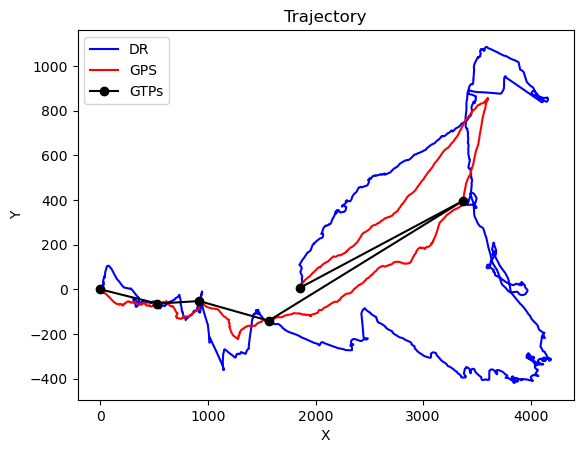

In [25]:
# Get data for plotting
dr_x = dr_trajectory['DR_x']
dr_y = dr_trajectory['DR_y']
utm_x = dr_trajectory['UTM_E'] - dr_trajectory.loc[0,'UTM_E']
utm_y = dr_trajectory['UTM_N'] - dr_trajectory.loc[0,'UTM_N']
gtps_x = gtps['UTM_E'] - dr_trajectory.loc[0,'UTM_E']
gtps_y = gtps['UTM_N'] - dr_trajectory.loc[0,'UTM_N']

# Initialize plot 
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y,  linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y,  linestyle='-', color='r', label='GPS')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

# Accelerometer Only Dead Reckoning

## Step A1: Calculate acceleration components

In [58]:
# Make a copy of the raw data
df_acc = df_raw.copy()

In [59]:
# CALCULATE STATIC ACCELERATION
w = 10
df_acc['Gx'] = df_acc['Acc_x'].rolling(window=w).mean()
df_acc['Gy'] = df_acc['Acc_y'].rolling(window=w).mean()
df_acc['Gz'] = df_acc['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df_acc = df_acc.iloc[w-1:].reset_index(drop=True)

In [60]:
# Calculate Dynamic Acceleration
df_acc['DAx'] = df_acc['Acc_x'] - df_acc['Gx']
df_acc['DAy'] = df_acc['Acc_y'] - df_acc['Gy']
df_acc['DAz'] = df_acc['Acc_z'] - df_acc['Gz']

## Step A2: Approximate velocity

In [61]:
# Approximate velocity as acceleration * time

df_acc['v_x'] = abs((df_acc['DAx']))
df_acc['v_y'] = abs((df_acc['DAy']))
df_acc['v_z'] = abs((df_acc['DAz']))

# df_acc['v_x'] = df_acc['Acc_x']**2
# df_acc['v_y'] = df_acc['Acc_y']**2
# df_acc['v_z'] = df_acc['Acc_z']**2

# df_acc['v_x'] = df_acc['Gx']
# df_acc['v_y'] = df_acc['Gy']
# df_acc['v_z'] = df_acc['Gz']

## Step A3: Approximate change in position

In [62]:
df_acc['dx'] = df_acc['v_x']/2
df_acc['dy'] = df_acc['v_y']/2
df_acc['dz'] = df_acc['v_z']/2

## Step A4: Compute pitch and roll

In [63]:
# COMPUTE Pitch
# Function to compute pitch
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute pitch
df_acc['pitch']=df_acc.apply(calculate_pitch,axis=1)

In [64]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df_acc['roll']=df_acc.apply(calculate_roll,axis=1)

In [65]:
df_acc[['Acc_x','DAx','Gx']].head()

,Acc_x,DAx,Gx
0,0.178736,0.067214,0.111521
1,0.189478,0.050378,0.139099
2,0.182300,0.021128,0.161172
3,0.194287,0.017878,0.176409
4,0.189502,0.009006,0.180496


## Step A5: Perform initial dead-reckoning

In [66]:
# Set start and end for calculation
T = 6 # total time in hrs
start = 2 * 60 * 60
end = (T * 60 * 60) + start
df_acc = df_acc.iloc[start:end]

# Extract ground truth points
gtps = df_acc[df_acc['ground_truth'] == 1].reset_index()

# Filter DF to perform dead reckoning between first and last GTP
# Get ground truth points
gtp_start = gtps.iloc[0]
gtp_end = gtps.iloc[-1]

# Get timestamps of GTPs
gtp_start_ts = gtp_start['datetime']
gtp_end_ts = gtp_end['datetime']

# Filter for DR pts that fall between gtp1 and gtp2
df_acc = df_acc[(df_acc['datetime'] >= gtp_start_ts) & (df_acc['datetime'] <= gtp_end_ts)]

In [67]:
# Reset the index
df_acc = df_acc.reset_index()

# Initialize columns for dead-reckoned coordinates
df_acc['DR_x'] = -999.0
df_acc.loc[0,'DR_x'] = 0
df_acc['DR_y'] = -999.0
df_acc.loc[0,'DR_y'] = 0
df_acc['DR_z'] = -999.0
df_acc.loc[0,'DR_z'] = -999.0
df_acc['DR_utm_x'] = -999.0
df_acc.loc[0,'DR_utm_x'] = df_acc.loc[0,'UTM_E']
df_acc['DR_utm_y'] = -999.0
df_acc['DR_utm_y'] = df_acc.loc[0,'UTM_N']

In [68]:
# Initialize position
position = np.array([[0],[0],[0]])

In [69]:
# Perform initial dead reckoning calculation
for i in range(0,len(df_acc)-1):
    #Construct the rotation matrix
    pitch = df_acc.loc[i,'pitch']
    roll = df_acc.loc[i,'roll']
    Rx = get_rx(pitch)
    Ry = get_ry(roll)
    rotation_matrix = Ry @ Rx

    # Compute the displacement vector
    dx = df_acc.loc[i,'dx']
    dy = df_acc.loc[i,'dy']
    dz = df_acc.loc[i,'dz']
    displacement_vector = rotation_matrix @ np.array([[dx],[dy],[dz]])
    #displacement_vector =  np.array([[dx],[dy],[dz]])
        
    # Perform initial calculation of coordinates
    current_position = position
    next_position = current_position + displacement_vector
    df_acc.loc[i+1,'DR_x'] = next_position[0]
    df_acc.loc[i+1,'DR_utm_x'] = displacement_vector[0] + df_acc.loc[i,'DR_utm_x']
    df_acc.loc[i+1,'DR_y'] = next_position[1]
    df_acc.loc[i+1,'DR_utm_y'] = displacement_vector[1] + df_acc.loc[i,'DR_utm_y']
    df_acc.loc[i+1,'DR_z'] = next_position[2]

    # Update position
    position = next_position

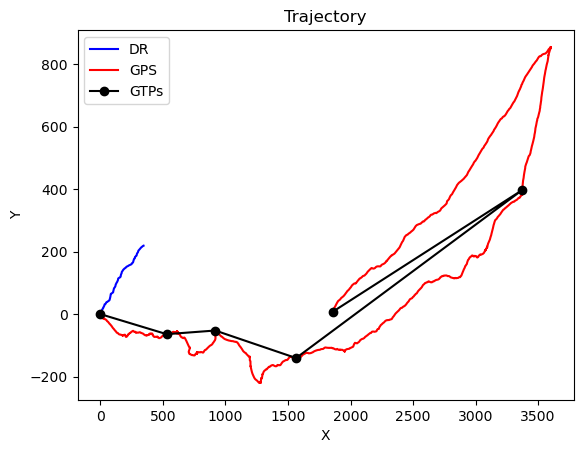

In [70]:
# Get data for plotting
dr_x = df_acc['DR_x']
dr_y = df_acc['DR_y']
utm_x = df_acc['UTM_E'] - df_acc.loc[0,'UTM_E']
utm_y = df_acc['UTM_N'] - df_acc.loc[0,'UTM_N']
gtps_x = gtps['UTM_E'] - df_acc.loc[0,'UTM_E']
gtps_y = gtps['UTM_N'] - df_acc.loc[0,'UTM_N']

# Initialize plot 
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y,  linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y,  linestyle='-', color='r', label='GPS')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

In [71]:
df_acc.head()

,index,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,...,dx,dy,dz,pitch,roll,DR_x,DR_y,DR_z,DR_utm_x,DR_utm_y
0,9351,0.316651,-0.123462,-0.957544,-0.003076,-0.112793,-0.250342,2019-02-26 01:00:00,1.0,26/02/2019,...,0.009744,0.032958,0.001604,0.336001,0.336001,0.000000,0.000000,-999.000000,479589.498904,7.106822e+06
1,9352,0.325123,-0.123462,-0.973120,-0.003467,-0.112793,-0.250097,2019-02-26 01:00:01,1.0,26/02/2019,...,0.004249,0.026545,0.005343,0.332857,0.332857,0.012282,0.031644,-0.005617,479589.511187,7.106822e+06
2,9353,0.321485,-0.105518,-0.961133,-0.004761,-0.112036,-0.248828,2019-02-26 01:00:02,1.0,26/02/2019,...,0.004568,0.011639,0.000593,0.329815,0.329815,0.017482,0.058478,-0.007653,479589.516387,7.106822e+06
3,9354,0.321485,-0.118677,-0.973095,-0.003418,-0.111914,-0.250904,2019-02-26 01:00:03,1.0,26/02/2019,...,0.003127,0.011807,0.004968,0.326510,0.326510,0.022843,0.069682,-0.009209,479589.521747,7.106822e+06
4,9355,0.309449,-0.085083,-0.971899,-0.005200,-0.109155,-0.250928,2019-02-26 01:00:04,1.0,26/02/2019,...,0.007882,0.009663,0.003711,0.323458,0.323458,0.025511,0.082458,-0.007336,479589.524415,7.106822e+06


## Step A4: Perform Corrections

In [72]:
# Perform heading and distance corrections
# Apply correction to each group
df_step = df_acc.copy()
df_step['rowID'] = range(0,len(df_step))

# Initialize empty data frame
trajectory = pd.DataFrame(columns=df.columns)

# Get initial utm coords
utm_x0 = df_acc.loc[0,"UTM_E"]
utm_y0 = df_acc.loc[0,"UTM_N"]

# Apply corrections between each set of ground truth points
for i in range(0,len(gtps)-1):
    # Get ground truth points
    gtp0 = gtps.iloc[i]
    gtp1 = gtps.iloc[i+1]
    
    # Get timestamps of GTPs
    gtp0_ts = gtp0['datetime']
    gtp1_ts = gtp1['datetime']
    
    # Filter for DR pts that fall between gtp1 and gtp2
    df_filt = df_step[(df_step['datetime'] >= gtp0_ts) & (df_step['datetime'] <= gtp1_ts)]
    rowIDs = df_filt['rowID'].to_list()
    s = rowIDs[0]
    e = rowIDs[-1] 
    
    # Get GPS coords (centered at 0,0)
    gps_x0 = gtp0['UTM_E'] - utm_x0
    gps_y0 = gtp0['UTM_N'] - utm_y0
    gps_x1 = gtp1['UTM_E'] - utm_x0
    gps_y1 = gtp1['UTM_N'] - utm_y0
    
    # Get dead reckoned coords
    dr_x0 = df_filt.loc[df_filt['rowID'] == s,'DR_x'].values
    dr_y0 = df_filt.loc[df_filt['rowID'] == s,'DR_y'].values
    dr_x1 = df_filt.loc[df_filt['rowID'] == e,'DR_x'].values
    dr_y1 = df_filt.loc[df_filt['rowID'] == e,'DR_y'].values
    
    # Define center of rotation
    x_center = dr_x0
    y_center = dr_y0
    center_of_rotation = np.array([x_center,y_center,[0]])
    
    # Subtract center of rotation from pts
    gps_x0 = 0
    gps_y0 = 0
    gps_x1 = gps_x1 - x_center
    gps_y1 = gps_y1 - y_center
    dr_x0  = 0
    dr_y0 = 0
    dr_x1 = dr_x1 - x_center
    dr_y1 = dr_y1 - y_center
    
    # Calculate the distance correction factor
    dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
    dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
    dist_corr_fact = (dist_GPS/dist_dr)
    
    # Calculate heading correction factor
    bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
    bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
    heading_corr_fact = (bearing_GPS-bearing_dr)
    if heading_corr_fact < -math.pi:
        heading_corr_fact += (360 * 0.0174533)
    elif heading_corr_fact > math.pi:
        heading_corr_fact -= (360 * 0.0174533)
    heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    
    # Get points that will be corrected
    Xs = df_step['DR_x'].to_numpy()
    Ys = df_step['DR_y'].to_numpy()
    Zs = np.zeros(len(df_step))
    initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation
    
    # Perform Correction
    new_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
    df_step['DR_x'] = new_coords[0]
    df_step['DR_y'] = new_coords[1]
    df_step['DR_z'] = new_coords[2]
    df_step['DR_utm_x'] = df_step['DR_x'] + utm_x0
    df_step['DR_utm_y'] = df_step['DR_y'] + utm_y0
    
    # snap end point to gps
    df_step.loc[e,'DR_utm_x'] == df_step.loc[e,'UTM_E']
    df_step.loc[e,'DR_utm_y'] == df_step.loc[e,'UTM_N']
    
    # Filter for rows between GTPs and append to df_corrected
    df_step_filt = df_step[(df_step['rowID'] >= s) & (df_step['rowID'] <= e)]
    trajectory = pd.concat([trajectory, df_step_filt], ignore_index=True)

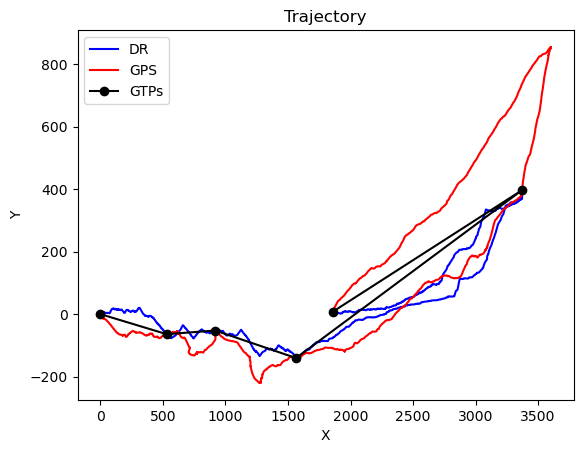

In [73]:
# Get data for plotting
dr_x = trajectory['DR_x']
dr_y = trajectory['DR_y']
utm_x = trajectory['UTM_E'] - trajectory.loc[0,'UTM_E']
utm_y = trajectory['UTM_N'] - trajectory.loc[0,'UTM_N']
gtps_x = gtps['UTM_E'] - df_acc.loc[0,'UTM_E']
gtps_y = gtps['UTM_N'] - df_acc.loc[0,'UTM_N']

# Initialize plot 
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y,  linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y,  linestyle='-', color='r', label='GPS')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()